Library import and data loading 

In [8]:


if 'libraries_imported' not in globals():
    libraries_imported = False

if not libraries_imported:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from datetime import datetime, timedelta

    # Plotly libraries
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import plotly.io as pio

    # SciPy libraries
    from scipy.interpolate import make_interp_spline
    from scipy.signal import butter, filtfilt

    # TensorFlow and Keras for neural networks
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
    from keras.wrappers.scikit_learn import KerasRegressor
    from keras.regularizers import l1_l2

    # Scikit-learn for model preparation and evaluation
    from sklearn.model_selection import train_test_split, KFold, GridSearchCV
    from sklearn.preprocessing import StandardScaler

    # Ensemble and boosting models
    from xgboost import XGBRegressor
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.tree import DecisionTreeRegressor

    # Additional utilities
    import logging
    import joblib 

        


    logging.getLogger('tensorflow').setLevel(logging.ERROR)

    # Optionally, to suppress absl (used by TensorFlow) messages as well:
    from absl import logging as absl_logging
    absl_logging.set_verbosity(absl_logging.ERROR)


    # Placeholder for DataFrame
    df_annotations = None

    # Set plot size for Seaborn
    sns.set(rc={'figure.figsize':(17,8.27)})

    # Set the flag to True to indicate libraries are imported
    libraries_imported = True

# Set plot size for Seaborn (outside the if condition)
sns.set(rc={'figure.figsize':(17,8.27)})


Functions 

In [9]:




def apply_fig_format(fig_x, w=2000, h=600, subplot=False, n_cols=1, n_rows=1):
    xaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
            dtick='D'
        )
    yaxis_args=dict(
            tickfont=dict(size=18),
            title_font=dict(size=22),
            gridcolor='lightgray',
            linecolor='gray',
            linewidth=1,
            mirror=True,
            showline=True,
        )

    fig_x.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        width=w,
        height=h,
     )

    if subplot:
        for i in range(1, n_cols*n_rows+1):
            fig_x['layout']['xaxis'+str(i)].update(xaxis_args)
            fig_x['layout']['yaxis'+str(i)].update(yaxis_args)
    else:
        fig_x['layout']['xaxis'].update(xaxis_args)
        fig_x['layout']['yaxis'].update(yaxis_args)




    fig_x.show()


def apply_date_range_df(df):
  df = df[df['datetime'].dt.date >= date_start]
  df = df[df['datetime'].dt.date <= date_end]
  return df

Data insepctions


In [10]:




joined_df = pd.read_csv('complete_data.csv')



joined_df.head()




joined_df.set_index('datetime', inplace=True)






joined_df_interpolated = joined_df.interpolate(method='linear')

# Apply backward fill
joined_df_interpolated_bfilled = joined_df_interpolated.bfill()

# Display the first few rows after processing to check for successful interpolation
joined_df_interpolated_bfilled.head()





dataset = joined_df_interpolated_bfilled
dataset.reset_index(inplace=True)

display(dataset.head())

fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['CO2'],
                         mode='lines',
                         line=dict(color='red'),
                         name='Interval Over Time'))

fig.update_layout(
    title="CH4%",
    xaxis_title="Datetime",
    yaxis_title="CH4%",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)


fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['sCOD_kg/m3'],
                         mode='lines',
                         line=dict(color='red'),
                         name='Interval Over Time'))

fig.update_layout(
    title="sCOD_kg/m3",
    xaxis_title="Datetime",
    yaxis_title="sCOD_kg/m3",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)



fig = go.Figure()

fig.add_trace(go.Scatter(x= dataset['datetime'],
                         y= dataset['A Current_daily_avg'],
                         mode='lines',
                         line=dict(color='red'),
                         name='A Current_daily_avg'))

fig.update_layout(
    title="A Current_daily_avg",
    xaxis_title="Datetime",
    yaxis_title="A Current_daily_avg",
    xaxis_showgrid=True,
    yaxis_showgrid=True
)

apply_fig_format(fig, 800, 300)


# dataset.to_csv('dataset.csv')


,datetime,Unnamed: 0,interval_minutes,index,ntp_volume_this_tip_intervalml,A Current,Peaks,Troughs,Peaks_daily_avg,Troughs_daily_avg,...,CH4%,CO2,H2S,TE,TS,VS,TSS,COND,VFA,sample_vol
0,2023-11-12 00:00:00,0,780.0,0.0,87.288242,48.264,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
1,2023-11-12 00:10:00,1,780.0,1042.0,80.825427,48.049,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
2,2023-11-12 00:20:00,2,780.0,1043.0,74.362613,47.909,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
3,2023-11-12 00:30:00,3,780.0,1044.0,67.899799,47.725,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0
4,2023-11-12 00:40:00,4,780.0,1045.0,61.436984,47.546,54.541,45.038,53.6395,44.738,...,58.7,40.0,1164.0,4.0,41.2,29.3,26.0,14.57,8505.0,15.0


Create lagged values

In [11]:

df = dataset.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby('datetime').mean()

df['A Current_daily_avg_lag1d_dt'] = df['A Current_daily_avg'].shift(freq='1D')
df['CH4%_lag1d_dt'] = df['CH4%'].shift(freq='1D')
df['CO2_lag1d_dt'] = df['CO2'].shift(freq='1D')
df['ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'] = df['ntp_volume_this_tip_intervalml_daily_avg'].shift(freq='1D')


df = df.bfill()
dataset = df.copy()
dataset.reset_index(inplace=True)



Inital NN trial

In [12]:


columns_to_drop = ['COD_kg/m3', 'TE', 'sCOD_kg/m3',  'sample_vol', 'index', 'TSS', 'VS', 'VFA', 'Unnamed: 0']
dataset = dataset.drop(columns=columns_to_drop, axis=1)






print(dataset.columns)

display(dataset)

# Drop rows where the target variable 'sCOD_kg/m3' is still missing after interpolation
# dataset = dataset.dropna(subset=['sCOD_kg/m3'])

# Select features and target variable
X = dataset.drop(['TS', 'datetime'], axis=1)  # Drop non-feature columns
y = dataset['TS']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define a list of models to evaluate
models = [
    Sequential([
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(1)
    ]),
    Sequential([
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(1)
    ]),
    Sequential([
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4), input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
        Dense(1)
    ])
]

# Create a dictionary to store model names and losses
model_losses = {}

# Compile and train each model
for i, model in enumerate(models):
    # Compile the model with a smaller learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    # Add a callback to check for NaN values during training
    class TerminateOnNaN(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if logs.get('loss') is not None and np.isnan(logs.get('loss')):
                print('NaN loss detected, stopping training')
                self.model.stop_training = True

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[TerminateOnNaN()])

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print(f"Model Loss: {loss}")

    # Add model name and loss to the dictionary
    model_losses[f"Model {i+1}"] = loss

# Print the model names and losses
for model_name, loss in model_losses.items():
    print(f"{model_name}: {loss}")



Index(['datetime', 'interval_minutes', 'ntp_volume_this_tip_intervalml',
       'A Current', 'Peaks', 'Troughs', 'Peaks_daily_avg', 'Troughs_daily_avg',
       'A Current_daily_avg', 'ntp_volume_this_tip_intervalml_daily_avg', 'pH',
       'CH4%', 'CO2', 'H2S', 'TS', 'COND', 'A Current_daily_avg_lag1d_dt',
       'CH4%_lag1d_dt', 'CO2_lag1d_dt',
       'ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt'],
      dtype='object')


,datetime,interval_minutes,ntp_volume_this_tip_intervalml,A Current,Peaks,Troughs,Peaks_daily_avg,Troughs_daily_avg,A Current_daily_avg,ntp_volume_this_tip_intervalml_daily_avg,pH,CH4%,CO2,H2S,TS,COND,A Current_daily_avg_lag1d_dt,CH4%_lag1d_dt,CO2_lag1d_dt,ntp_volume_this_tip_intervalml_daily_avg_lag1d_dt
0,2023-11-12 00:00:00,780.0,87.288242,48.2640,54.541,45.038,53.6395,44.7380,50.681660,178.331268,7.320000,58.700000,40.0,1164.0,41.200000,14.570000,50.681660,58.700000,40.000000,178.331268
1,2023-11-12 00:10:00,780.0,80.825427,48.0490,54.541,45.038,53.6395,44.7380,50.681660,178.331268,7.320000,58.700000,40.0,1164.0,41.200000,14.570000,50.681660,58.700000,40.000000,178.331268
2,2023-11-12 00:20:00,780.0,74.362613,47.9090,54.541,45.038,53.6395,44.7380,50.681660,178.331268,7.320000,58.700000,40.0,1164.0,41.200000,14.570000,50.681660,58.700000,40.000000,178.331268
3,2023-11-12 00:30:00,780.0,67.899799,47.7250,54.541,45.038,53.6395,44.7380,50.681660,178.331268,7.320000,58.700000,40.0,1164.0,41.200000,14.570000,50.681660,58.700000,40.000000,178.331268
4,2023-11-12 00:40:00,780.0,61.436984,47.5460,54.541,45.038,53.6395,44.7380,50.681660,178.331268,7.320000,58.700000,40.0,1164.0,41.200000,14.570000,50.681660,58.700000,40.000000,178.331268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465,2023-12-12 23:30:00,680.0,46.255124,46.4275,52.900,45.010,53.1000,44.9515,50.356366,98.108913,7.740756,58.963866,44.0,1086.0,70.450840,19.122467,50.355472,54.567904,44.856228,128.914634
4466,2023-12-12 23:40:00,680.0,43.031766,45.8760,52.900,45.010,53.1000,44.9515,50.356366,98.108913,7.740504,59.009244,44.0,1086.0,70.467227,19.101645,50.355472,54.588503,44.837305,128.914634
4467,2023-12-12 23:50:00,680.0,40.882861,45.5210,52.900,45.010,53.1000,44.9515,50.356366,98.108913,7.740336,59.039496,44.0,1086.0,70.478151,19.087763,50.355472,54.609102,44.818383,128.914634
4468,2023-12-13 00:00:00,680.0,38.733956,45.5210,52.900,45.010,53.1000,44.9515,50.356366,98.108913,7.740168,59.069748,44.0,1086.0,70.489076,19.073882,50.356366,54.629701,44.799461,98.108913


Epoch 1/10
112/112 [==============================] - 0s 553us/step - loss: 36.8052
Epoch 2/10
112/112 [==============================] - 0s 511us/step - loss: 5.6235
Epoch 3/10
112/112 [==============================] - 0s 542us/step - loss: 3.1688
Epoch 4/10
112/112 [==============================] - 0s 558us/step - loss: 2.3988
Epoch 5/10
112/112 [==============================] - 0s 484us/step - loss: 1.9603
Epoch 6/10
112/112 [==============================] - 0s 553us/step - loss: 1.7128
Epoch 7/10
112/112 [==============================] - 0s 515us/step - loss: 1.4755
Epoch 8/10
112/112 [==============================] - 0s 543us/step - loss: 1.3630
Epoch 9/10
112/112 [==============================] - 0s 517us/step - loss: 1.2175
Epoch 10/10
28/28 [==============================] - 0s 840us/step - loss: 1.0048
Model Loss: 1.0047980546951294
Epoch 1/10
112/112 [==============================] - 0s 622us/step - loss: 28.3548
Epoch 2/10
112/112 [==============================] - 0

Comparison of -- Keras regressor, XGBoost, Random Forest, Decision Tree, Gradient Boosting (with grid search and cross validation)

In [13]:

def create_model(layers=[64, 32, 16], input_shape=(10,), learning_rate=0.001):
    model = Sequential()
    model.add(Dense(layers[0], activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), input_shape=input_shape))
    for layer_size in layers[1:]:
        model.add(Dense(layer_size, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model

# Define a custom callback for handling NaN loss
class TerminateOnNaN(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and np.isnan(logs.get('loss')):
            print('NaN loss detected, stopping training')
            self.model.stop_training = True

# Define the list of models and their corresponding hyperparameters, including neural networks with varying architectures
models = [
    {
        'model': KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, input_shape=[X_train.shape[1]], verbose=0, callbacks=[TerminateOnNaN()]),
        'params': {
            # 'epochs': [10, 20, 30],
            # 'batch_size': [16, 32, 64],
            # 'layers': [[64, 32, 16], [128, 64, 32], [32, 16, 8]],
            # 'learning_rate': [0.01, 0.001, 0.0001]

            'epochs': [30],
            'batch_size': [32],
            'layers': [[128, 64, 32]],
            'learning_rate': [0.001]
        }

    },

        {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001]
        }
    },
    {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5]
        }
    },
    {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 4, 5]
        }
    },
    {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.001]
        }
    }


]


best_models = {}

# Perform grid search for each model, now including neural network architecture exploration
for i, model_info in enumerate(models):
    model = model_info['model']
    params = model_info['params']
    
    grid_search = GridSearchCV(model, params, cv=3, scoring='neg_mean_absolute_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"Best parameters for {model.__class__.__name__}: {best_params}")
    print(f"Best score for {model.__class__.__name__}: {best_score}")
    
    # Save the best model from the grid search
    best_model = grid_search.best_estimator_
    best_models[model.__class__.__name__] = best_model
    joblib.dump(best_model, f'model_{i}_{model.__class__.__name__}.joblib')



Fitting 3 folds for each of 1 candidates, totalling 3 fits


/tmp/ipykernel_115537/979667739.py:21: DeprecationWarning:

KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Best parameters for KerasRegressor: {'batch_size': 32, 'epochs': 30, 'layers': [128, 64, 32], 'learning_rate': 0.001}
Best score for KerasRegressor: -0.41850664636955237
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score for XGBRegressor: -0.05924626991884746
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for RandomForestRegressor: {'max_depth': 5, 'n_estimators': 300}
Best score for RandomForestRegressor: -0.5023722839676018
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best parameters for DecisionTreeRegressor: {'max_depth': 5}
Best score for DecisionTreeRegressor: -0.5716092938644977
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score for GradientBoostingRegressor: -0.05170036600504593


2024-02-16 20:37:07.652112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.655453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.728738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.745350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.758837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.771499: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.803323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-16 20:37:07.804768: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-

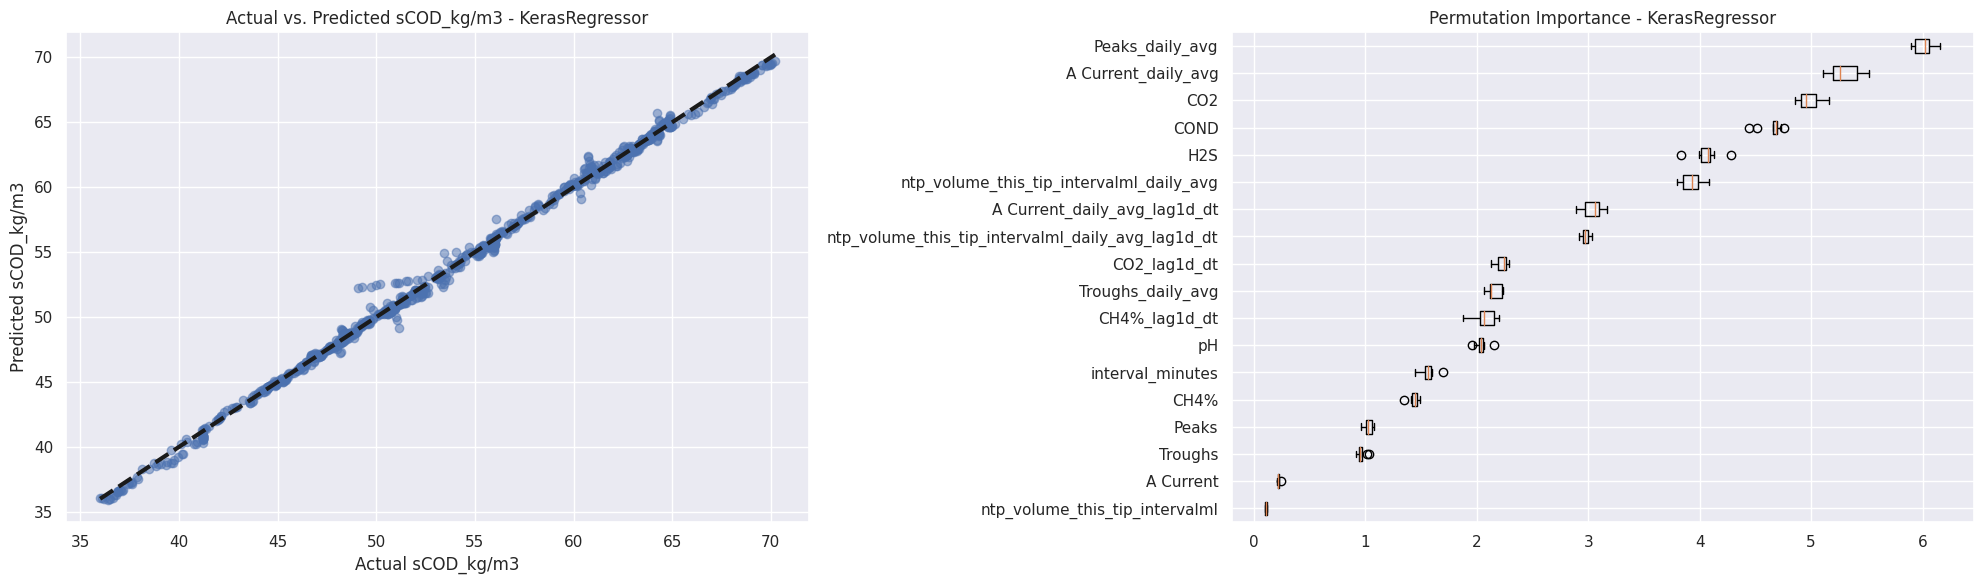

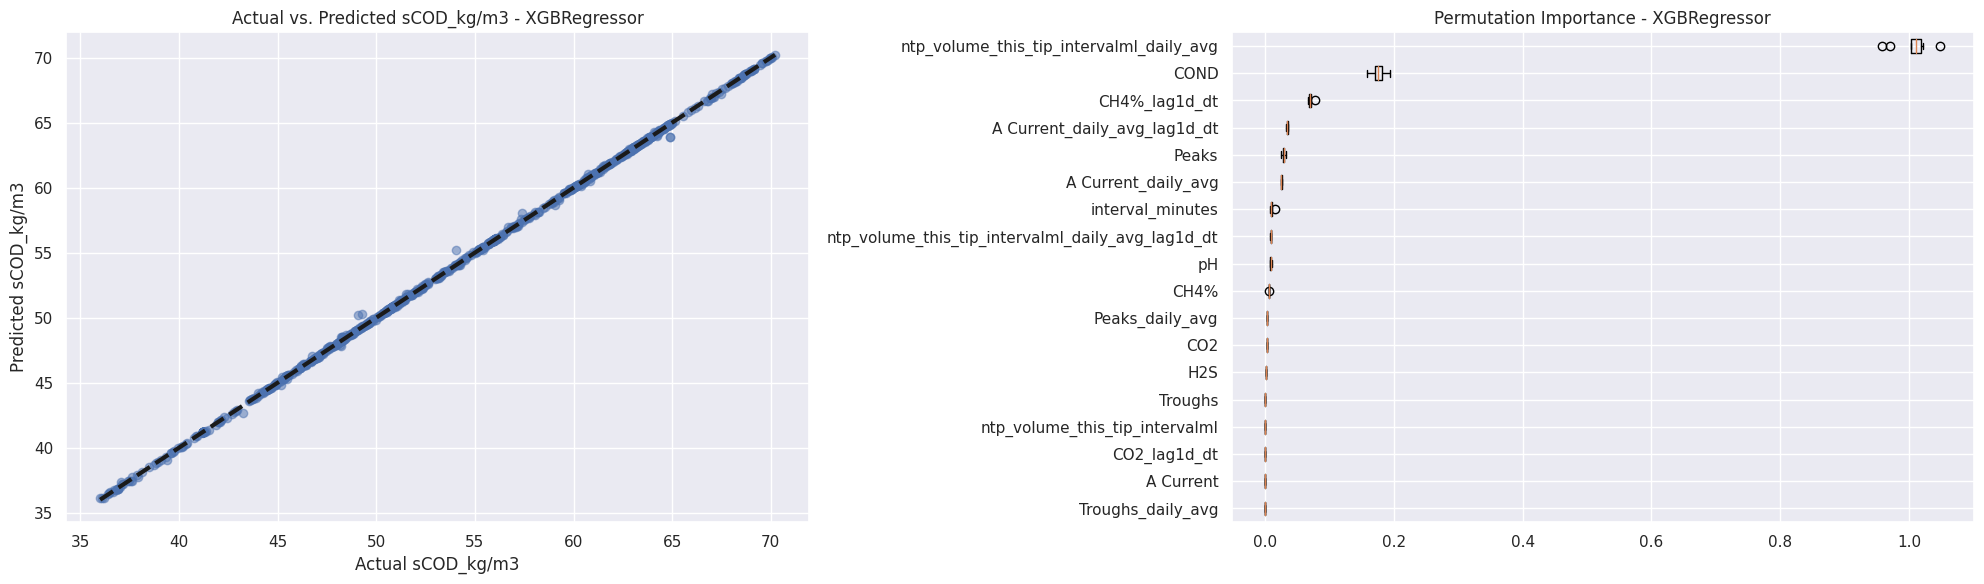

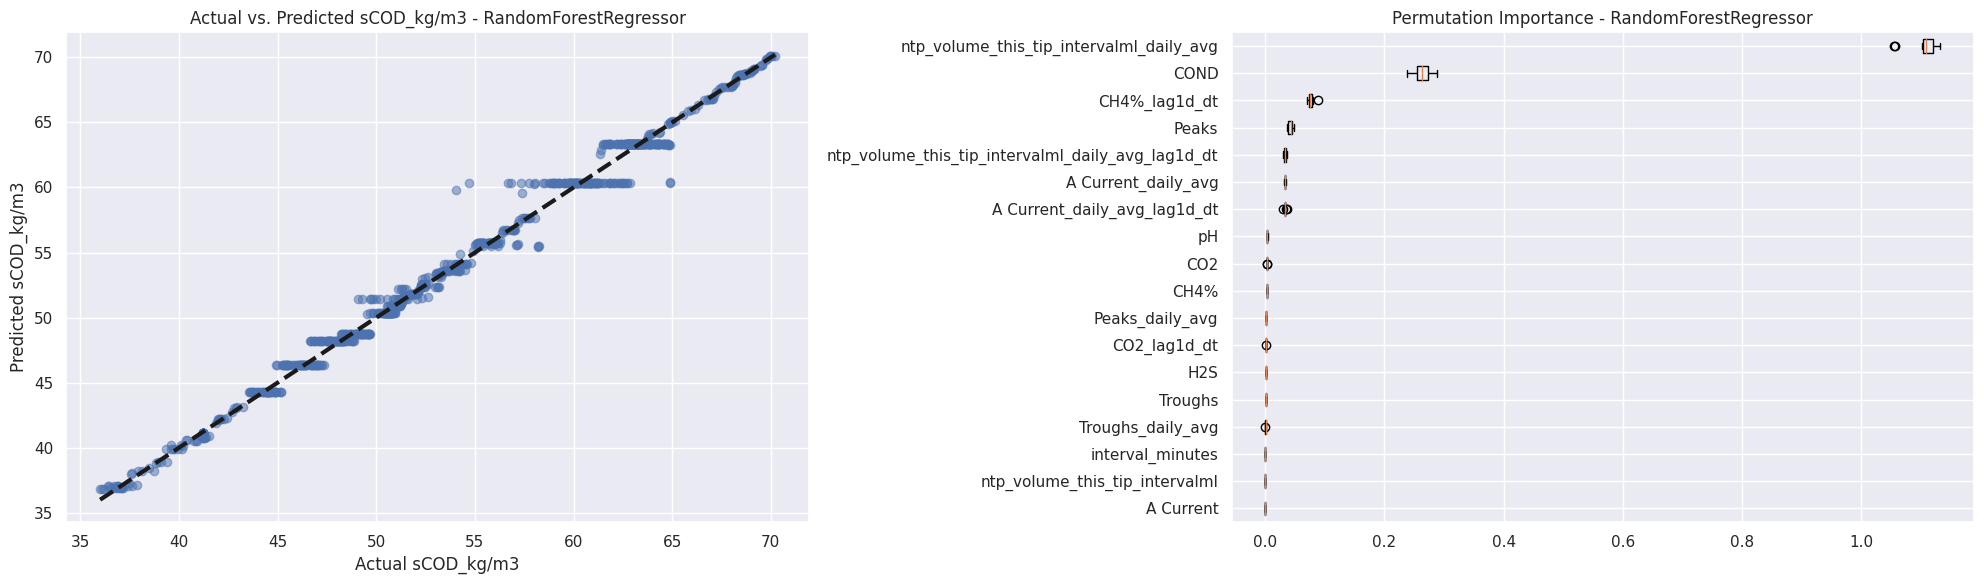

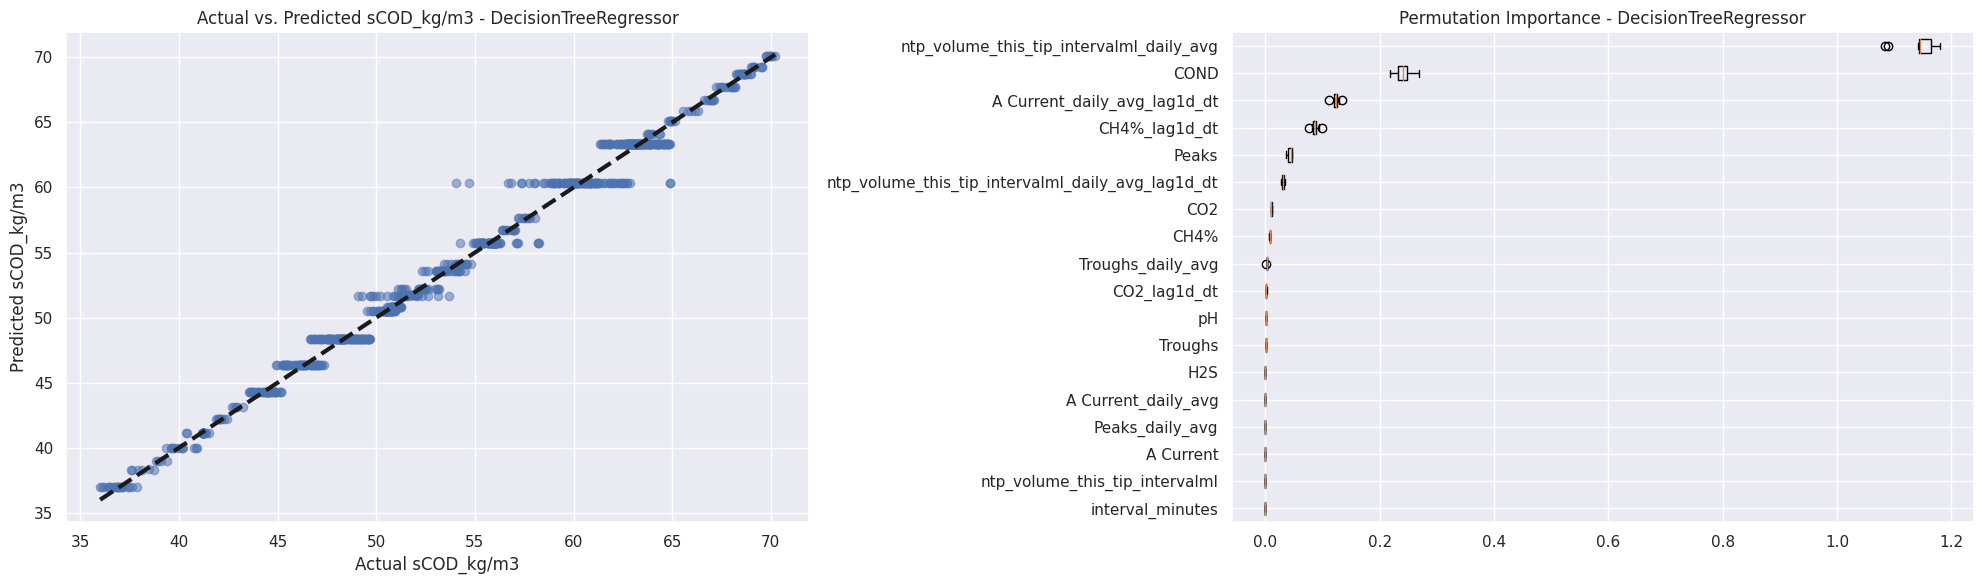

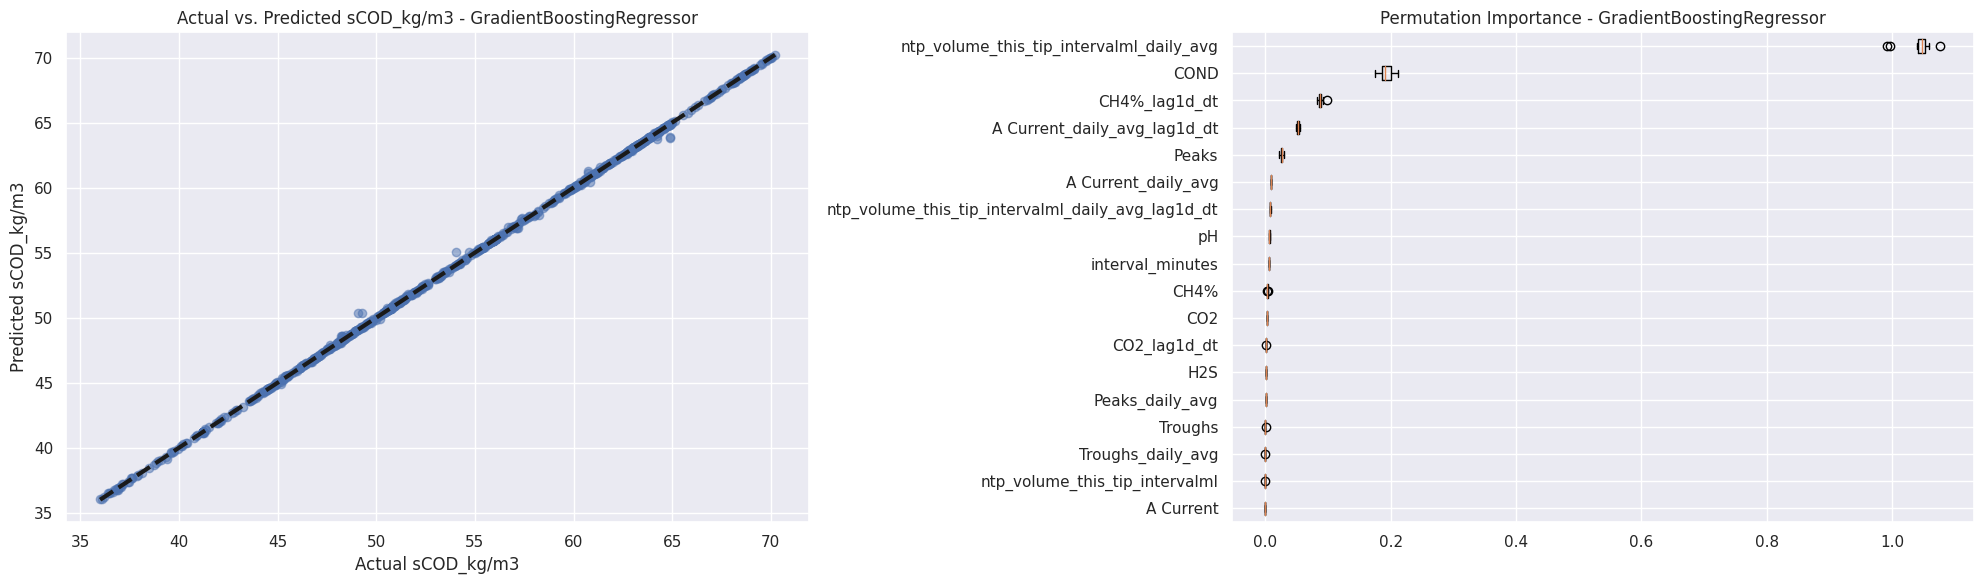

In [14]:
from sklearn.inspection import permutation_importance

feature_names = list(X.columns)

for model_name, model in best_models.items():
    # Generate predictions using the trained model
    y_pred = model.predict(X_test)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plotting the predictions vs the actual values on the first subplot
    axs[0].scatter(y_test, y_pred, alpha=0.5)
    axs[0].set_xlabel('Actual sCOD_kg/m3')
    axs[0].set_ylabel('Predicted sCOD_kg/m3')
    axs[0].set_title(f'Actual vs. Predicted sCOD_kg/m3 - {model_name}')
    axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Ideal line for perfect predictions

    # Compute permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    sorted_idx = result.importances_mean.argsort()

    # Plotting permutation importance on the second subplot
    axs[1].boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    axs[1].set_title(f'Permutation Importance - {model_name}')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()